In [4]:
import pandas as pd

df = pd.read_csv("../data/processed/cicids_binary_clean.csv")

print(df.shape)


(1048575, 79)


In [5]:
X = df.drop("BinaryLabel", axis=1)
y = df["BinaryLabel"]


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Split done")

Split done


In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Handle inf again just in case
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling complete")


Scaling complete


In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)

print("Model trained")


Model trained


In [9]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf.predict(X_test_scaled)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[133525      0]
 [     0  76190]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    133525
           1       1.00      1.00      1.00     76190

    accuracy                           1.00    209715
   macro avg       1.00      1.00      1.00    209715
weighted avg       1.00      1.00      1.00    209715



In [10]:
import joblib

joblib.dump(rf, "../models/random_forest_ids.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

print("Model saved")


Model saved


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rf.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:,1]))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 1.0
ROC-AUC: 1.0

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    133525
           1       1.00      1.00      1.00     76190

    accuracy                           1.00    209715
   macro avg       1.00      1.00      1.00    209715
weighted avg       1.00      1.00      1.00    209715



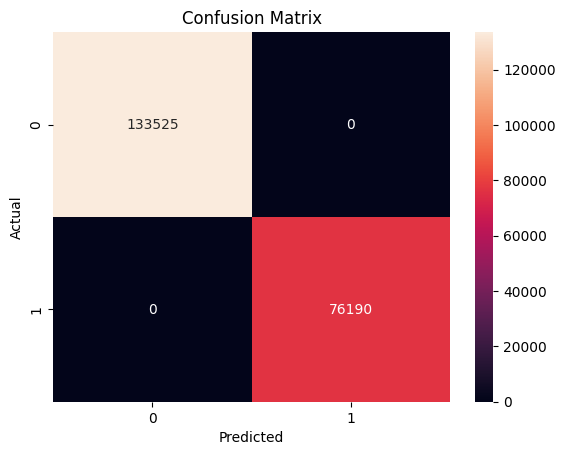

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [13]:
import joblib

joblib.dump(rf, "../models/random_forest_ids.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']